# Trabajo práctico 2 - *Burnout en empleados corporativos*
*Pablo Brahim - Kevin Pennington*

- [x]  Análisis de balance/desbalance de clases ante un posible problema de clasificación.
    - [x] Plantear/describir el problema y analizar la variable target.
    - [x] Proponer y aplicar mecanismos de balance en caso de ser necesario y justificar la
selección.
- [x] Análisis y selección de features:
    - [x] Implementar tests estadísticos para evaluar relaciones entre features.
    - [x] Realizar una selección de variables basándose en su relevancia y significancia.
    - [x] Justificar la elección de las variables seleccionadas.
    - [x] Crear nuevos features en caso de ser necesario. Justificar.
- [x] Transformación de variables:
    - [x] Aplicar técnicas de conversión de variables, por ejemplo: codificación, discretización.
    - [x] Escalar y / o normalizar los features.
- [x] Reducción de la dimensionalidad:
    - [x] Implementar dos técnicas de reducción de la dimensionalidad. Comparar.
    - [x] Comparar el dataset original con el dataset reducido, evaluando las ventajas y
desventajas de la reducción.
    - [x] Analizar cómo la reducción de la dimensionalidad afecta la interpretación y el
rendimiento de futuros modelos predictivos.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
%pip install imblearn
from imblearn.over_sampling import SMOTE

Note: you may need to restart the kernel to use updated packages.


In [5]:
try:
    df = pd.read_parquet("./dataset_burnout.parquet.gzip")
except ImportError:
    %pip install pyarrow
    df = pd.read_parquet("./dataset_burnout.parquet.gzip")

## Descripción del problema y analisis de la variable target

Queremos predecir el brunout de los empleados, usamos el burn_rate como proxy.<br>

Podemos plantear un problema de clasificacion binaria (por ejemplo si el burn rate es mayor que cierto umbral) <br>
Intentando predecir si un determinado empleado presenta o no *burnout* <br>

Otra opcion es intentar predecir el nivel de burnout, para esto seria necesario transformar el target<br>
en una variable categorica ordinal, con determinados niveles de *burnout* ya que, como vimos<br>
en el trabajo anterior esta variable es continua, con valores entre 0 y 1

Analizamos un poco la variable target para ver como discretizarla.<br>
Creamos cuatro categorias para el burnout: Bajo, Medio, Alto y Muy Alto<br>

<Axes: xlabel='burn_rate', ylabel='Count'>

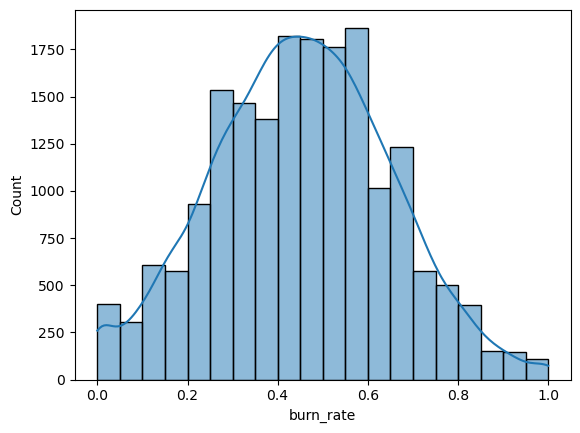

In [9]:
sns.histplot(data=df, x='burn_rate', bins=20, kde=True)

## Transformación del target - Discretizacion
En esta seccion analizamos la variable target *burn rate* y como
discretizarla. Lo hacemos sobre el dataset completo a modo de analisis
pero para evitar *data leakage* (como podria pasar si se usa la distribucion
de medias cercanas como criterio) haremos el fit nuevamente
luego de separar los datasets de entrenamiento y validacion, de ser necesario.

In [11]:
""" helper function hecha en clase"""
def plot(new_var):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    sns.histplot(data=df, x="burn_rate", hue=new_var, multiple="stack", bins=20, palette="Set2", ax=axes[0])
    axes[0].set_title(f"Histograma por categoría ({new_var})")
    axes[0].set_xlabel("burn_rate")
    axes[0].set_ylabel("Frecuencia")

    sns.scatterplot(data=df, x=df.index, y="burn_rate", hue=new_var, palette="Set2", ax=axes[1])
    axes[1].set_title('Discretización')
    axes[1].set_ylabel("Categoría")
    axes[1].set_xlabel("burn_rate" )

    sns.countplot(x=new_var, data=df, hue=new_var, palette="Set2", ax=axes[2])
    axes[2].set_xlabel("Categoría")
    axes[2].set_ylabel("Cantidad de empleados")
    axes[2].set_title("Distribución de empleados según burn rate")

    plt.tight_layout()
    plt.show()

### Opción 1) Intervalos igual longitud

En primer lugar probamos el caso mas sencillo que es dividir todo el rango de burn rate<br>
en intervalos de igual longitud<br>

In [13]:
df["equal_width"] = pd.cut(df["burn_rate"], bins=4, labels=["Bajo", "Medio", "Alto", "Muy Alto"])

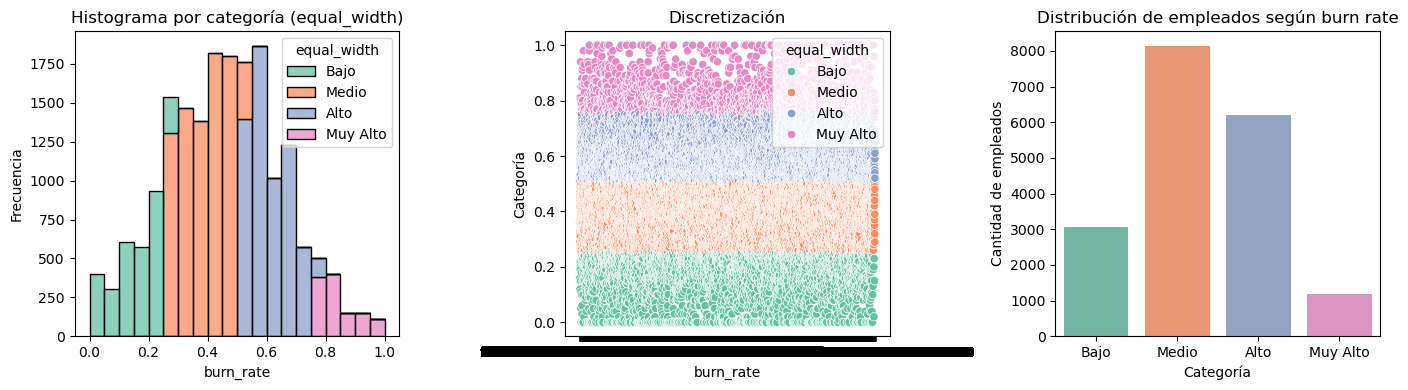

In [14]:
plot('equal_width')

Lo que tiene de positivo esta discretizacion es que la interpretacion de los rangos de burnout es clara
el problema es que, naturalmente, los datos no se distribuyen uniformemente en esos intervalos.
El desbalance de clases es muy alto; en particular, la forma de la cola de la distribucion hace
que la clase "Muy Alto" tenga muy pocos valores comparativamente.

###  Opción 2) Intervalos igual frecuencia

Se pueden separar en intervalos con la misma cantidad de cuentas para intentar remediar el desbalance de la discretizacion anterior.
La contra de esto es que los intervalos resultantes pueden no ser muy descriptivos.

In [17]:
df["equal_freq"], bins = pd.qcut(df["burn_rate"], q=4, labels=["Bajo", "Medio", "Alto", "Muy Alto"], retbins=True)

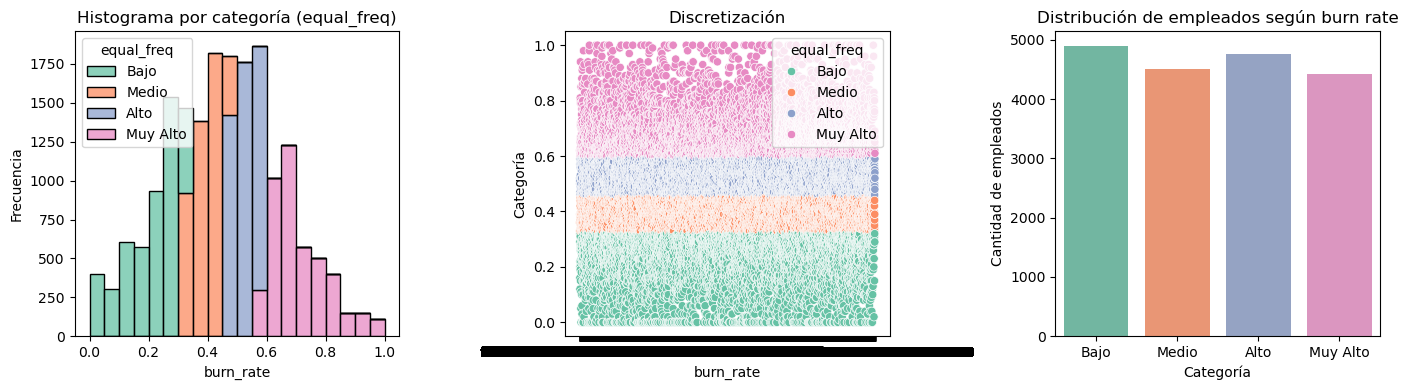

In [18]:
plot('equal_freq')

En efecto, el desbalance de clase mejora al punto de practicamente desaparecer. <br>
Pero los intervalos centrales son muy acotados y tienen muy poca dispersión.

###  Opción 3) k-means cluster

Probamos con una clusterizacion por k-medias<br>

In [21]:
kbin_kmeans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
df["kbin_kmeans"] = kbin_kmeans.fit_transform(df[["burn_rate"]]).astype(int)

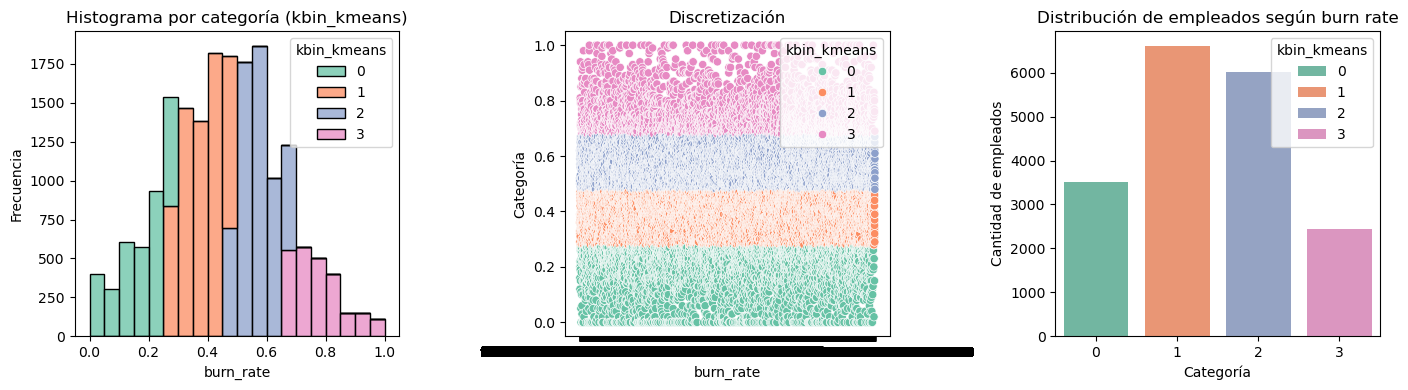

In [22]:
plot("kbin_kmeans")

En este caso, la discretizacion resultante parece un *punto medio* entre las dos anteriores.<br>
Existe desbalance (bastante marcado para la clase 3) pero no tanto como para los intervalos
de igual longitud.
Los intervalos creados por esta clusterizacion estan un poco mejor distribuidos que los creados
por los intervalos de mejor frecuencia.

### Eleccion de discretizacion


In [25]:
print(f"desbalance de clases para intervalos de igual longitud: {df.equal_width.value_counts().iloc[0] / df.equal_width.value_counts().iloc[3]:.2f}")
print(f"desbalance de clases para intervalos de k-medias: {df.kbin_kmeans.value_counts().iloc[0] / df.kbin_kmeans.value_counts().iloc[3]:.2f}")

desbalance de clases para intervalos de igual longitud: 6.86
desbalance de clases para intervalos de k-medias: 2.71


Se puede ver que el desbalance de clases en el caso de k-medias es mucho mejor (menor) que para los intervalos de igual longitud<br>
Podemos cuantificar esto tambien mirando la entropia de shannon para las distintas variables<br>

In [27]:
def shannon_entropy(y):
    probs = y.value_counts(normalize=True)
    return -np.sum(probs * np.log2(probs))
print("Entropia de shannon")
print(f"intervalos de igual longitud:\t{shannon_entropy(df.equal_width):.2f}")
print(f"intervalos de igual frecuencia:\t{shannon_entropy(df.equal_freq):.2f}")
print(f"intervalos k medias:\t\t{shannon_entropy(df.kbin_kmeans):.2f}")

Entropia de shannon
intervalos de igual longitud:	1.73
intervalos de igual frecuencia:	2.00
intervalos k medias:		1.90


Creemos ademas que los rangos comprendidos por las distintas categorías para la discretización por k-medias son aceptables.<br>
Por este motivo, conservamos esta discretizacion para la variable target

In [29]:
df = df.drop(columns=["equal_width", "equal_freq", "kbin_kmeans"])
df.head(5)

,date_of_joining,gender,company_type,wfh_setup_available,designation,resource_allocation,mental_fatigue_score,burn_rate,work_hours_per_week,sleep_hours,work-life_balance_score,manager_support_score,deadline_pressure_score,team_size,recognition_frequency,day_of_joining,days_since_joined
Employee ID,,,,,,,,,,,,,,,,,
fffe32003000360033003200,2008-09-30,Female,Service,No,2,3.0,3.8,0.16,35,7.5,3,3,1,16,2,274,93
fffe3700360033003500,2008-11-30,Male,Service,Yes,1,2.0,5.0,0.36,41,7.1,5,3,3,10,5,335,32
fffe32003400380032003900,2008-11-03,Male,Service,Yes,1,1.0,2.6,0.20,43,6.7,3,3,1,13,2,308,59
fffe31003900340031003600,2008-07-24,Female,Service,No,3,7.0,6.9,0.52,51,5.2,1,3,4,18,0,206,161
fffe3300350037003500,2008-11-26,Male,Product,Yes,2,4.0,3.6,0.29,41,7.0,4,4,3,9,5,331,36


## Transformación de variables

### Codificacion pre split
Hacemos una codificacion y tratamineto previo de las columnas del dataset.
Ya vimos en el trabajo anterior que las variables gender, company_type y wfh_setup_available toman
dos valores posibles cada una. Por lo tanto, es directo mapearlos a 0,1 cada una.<br>
Ademas (tambien discutido en el TP 1) podemos dropear date_of_joining, ya que se crearon
dos nuevos features que consideramos mas informativos que la fecha particular

In [32]:
df["gender"] = df["gender"].map({"Male": 0, "Female": 1})
df["company_type"] = df["company_type"].map({"Service": 0, "Product": 1})
df["wfh_setup_available"] = df["wfh_setup_available"].map({"No": 0, "Yes": 1})
df = df.drop("date_of_joining", axis=1)

Ahora todas las variables son numéricas

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18590 entries, fffe32003000360033003200 to fffe3400350031003800
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   18590 non-null  int64  
 1   company_type             18590 non-null  int64  
 2   wfh_setup_available      18590 non-null  int64  
 3   designation              18590 non-null  int64  
 4   resource_allocation      18590 non-null  float64
 5   mental_fatigue_score     18590 non-null  float64
 6   burn_rate                18590 non-null  float64
 7   work_hours_per_week      18590 non-null  int64  
 8   sleep_hours              18590 non-null  float64
 9   work-life_balance_score  18590 non-null  int64  
 10  manager_support_score    18590 non-null  int64  
 11  deadline_pressure_score  18590 non-null  int64  
 12  team_size                18590 non-null  int64  
 13  recognition_frequency    18590 non-null  in

### Split train test

In [36]:
X_raw = df.drop(columns=["burn_rate"], axis=1)
y_raw = df.burn_rate

En primer lugar hacemos el train test split para evitar data leakage.
Como ademas el balance de clases lo hacemos para el train set
usamos `stratify=y` en el split para garantizar cierta presencia de las clases con menor ocurrencia en el set de prueba.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)
print("Tamaño train:", X_train.shape, "Test:", X_test.shape)

Tamaño train: (14872, 15) Test: (3718, 15)


### discretizacion de target
Ahora fiteamos con el metodo elegido en la primera seccion, y hacemos `transform` sobre train y test

In [40]:
kbin_kmeans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
y_train = kbin_kmeans.fit_transform(y_train.values.reshape(-1, 1)).astype(int).squeeze()
y_test = kbin_kmeans.transform(y_test.values.reshape(-1, 1)).astype(int).squeeze()

## Normalizacion y estandarizacion
Una vez que estan separados los sets de entrenamiento y validacion, podemos normalizar/estandarizar
sin que haya filtracion de informacion al set de prueba.

Ponemos las ordinales juntas porque no vamos a hacer el encoding, solo hay que estandarizar.
Lo hacemos en una pipeline por completitud. Pero como el trabajo de imputacion, manejo de
outliers y encoding ya esta heredado del tp anterior, la pipeline solo estandariza.

In [43]:
""" como no hacemos encoding ni nada de eso,
no hace falta tratamiento separado para distintos tipos de 
variables. Ademas vamos a estandarizar tambien las categoricas
pues es necesario igualdad de escala para ciertos algoritmos
"""
# num_vars = [
#     "designation",               
#     "resource_allocation",       
#     "mental_fatigue_score",      
#     "work_hours_per_week",       
#     "sleep_hours",               
#     "work-life_balance_score",  
#     "manager_support_score",     
#     "deadline_pressure_score",  
#     "team_size",                 
#     "recognition_frequency",    
#     "day_of_joining",          
#     "days_since_joined",
# ] 
# num_transform = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [44]:
pipeline

Pipeline(steps=[('scaler', StandardScaler())])

In [45]:
pipeline.fit(X_train) 
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

reconstruimos el dataframe a partir del array transformado

In [47]:
X_train_preproc = pd.DataFrame(X_train, columns=X_raw.columns)
X_test_preproc = pd.DataFrame(X_test, columns=X_raw.columns)


In [48]:
X_train_preproc

,gender,company_type,wfh_setup_available,designation,resource_allocation,mental_fatigue_score,work_hours_per_week,sleep_hours,work-life_balance_score,manager_support_score,deadline_pressure_score,team_size,recognition_frequency,day_of_joining,days_since_joined
0,0.957853,-0.732802,-1.084958,0.721370,0.741819,0.608818,0.026425,-1.589843,-0.374588,0.145911,1.093731,0.194394,-1.022120,-0.618134,0.618134
1,0.957853,-0.732802,0.921695,-1.045027,-0.727070,-0.381303,0.814521,-0.913313,-1.094617,0.145911,0.375555,-0.619578,-1.022120,-0.874782,0.874782
2,-1.044001,1.364625,-1.084958,-0.161829,0.741819,-0.016521,0.945870,-0.349539,-0.374588,-0.640604,0.375555,1.008366,-1.022120,-1.416594,1.416594
3,-1.044001,-0.732802,0.921695,0.721370,0.252189,-0.589750,1.471267,-1.026068,-1.094617,-0.640604,1.093731,-0.823071,-0.430827,-1.454616,1.454616
4,-1.044001,-0.732802,-1.084958,0.721370,1.231449,1.129935,1.471267,0.326991,-1.094617,-0.640604,1.093731,-0.823071,-0.430827,-0.551596,0.551596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14867,0.957853,-0.732802,0.921695,-0.161829,-0.237440,-0.485526,-0.893019,1.567295,1.785501,1.718941,-1.060797,-1.637044,1.343053,-1.426099,1.426099
14868,-1.044001,-0.732802,-1.084958,0.721370,1.721078,0.869377,0.026425,-1.589843,-1.094617,0.145911,0.375555,-0.619578,-0.430827,0.446479,-0.446479
14869,0.957853,-0.732802,0.921695,-0.161829,0.741819,1.859498,0.814521,-1.815353,-1.094617,-1.427118,1.093731,1.211859,-0.430827,1.663180,-1.663180
14870,0.957853,1.364625,0.921695,0.721370,1.231449,0.608818,0.814521,-1.251578,-0.374588,0.145911,1.093731,-0.823071,-0.430827,-1.274012,1.274012


##  Análisis y seleccion de features

### 1) Correlacion entre features

Miramos correlacion; para capturar no linealidad, usamos correlacion de Spearman.
Esto nos da una idea de qué features pueden llegar a ser buenos predictores
y qué grupos de features pueden ser redundantes entre si.

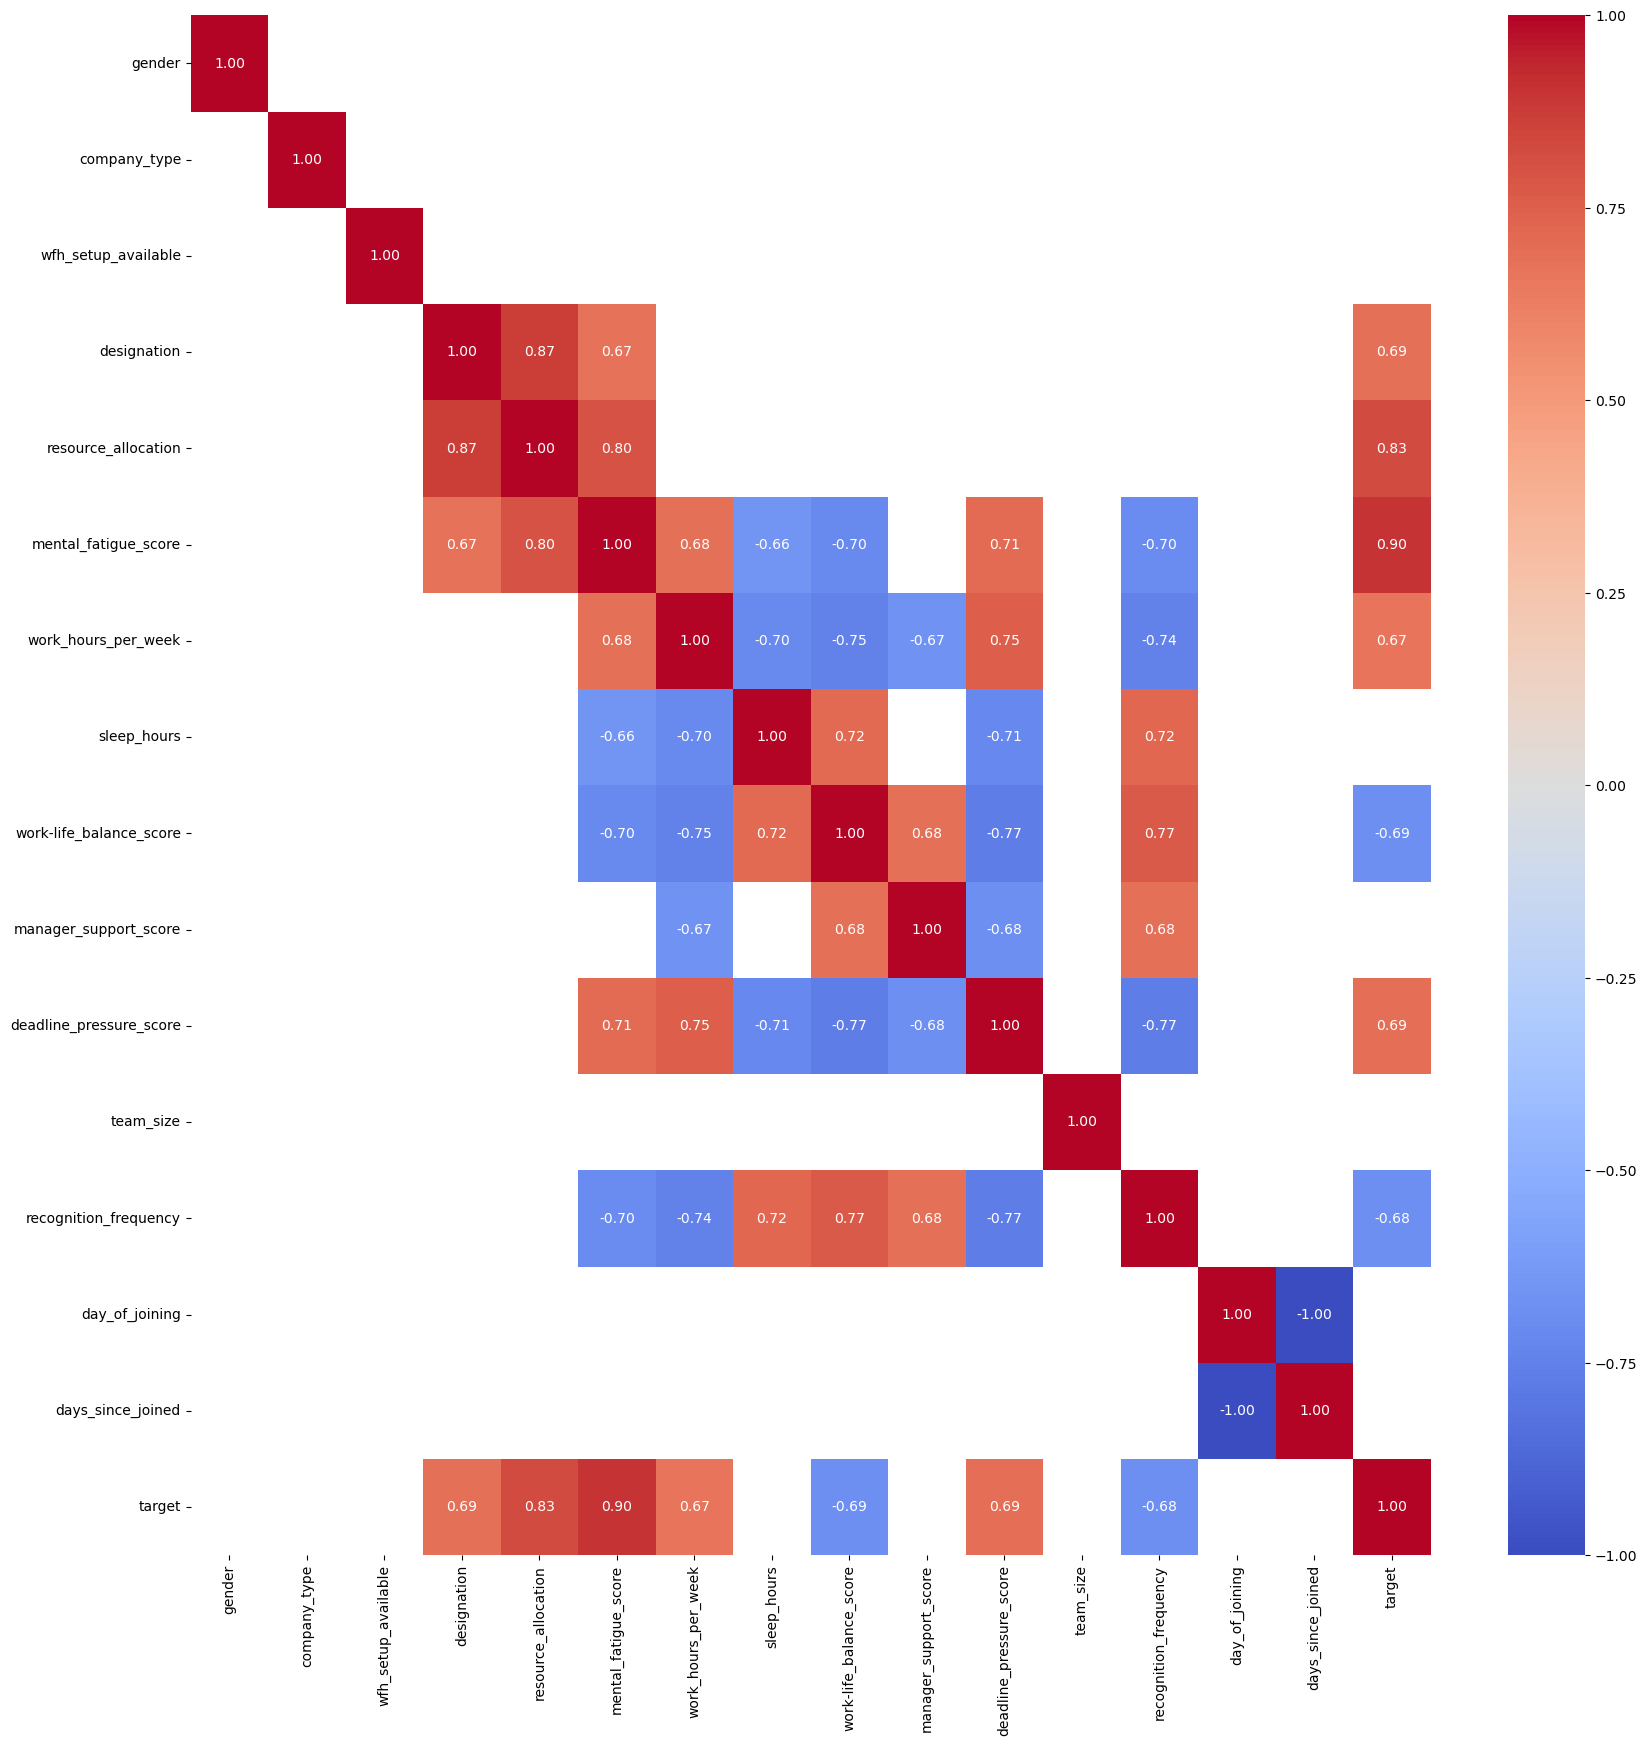

In [52]:
datos_train_corr = X_train_preproc.copy()
datos_train_corr['target'] = y_train.copy()
umbral = 0.65
mask_for_heatmap = (datos_train_corr.corr(method='spearman').abs() < umbral)
plt.figure(figsize=(20,20))
sns.heatmap(
    datos_train_corr.corr(method='spearman'), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)
plt.show()

Features como *designation*, *resource_allocation*, *mental_fatigue_score* y *deadline_preassure_score* tienen buena correlacion con el target, por lo que pueden llegar a ser buenos predictores del mismo. No tiramos nada aun, aunque hay varios features que estan muy
correlacionados entre si.


### 2) KBest select

Evalúa cada feature individualmente según su relación con el target, identificar los features con mayor poder predictivo individual.

In [56]:
selector_mi = SelectKBest(score_func=mutual_info_classif, k=15) 
selector_mi.fit(X_train_preproc, y_train) 
selected_indices = selector_mi.get_support()
selected_features = X_train_preproc.columns[selected_indices]
scores = selector_mi.scores_[selected_indices]
feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'F_Score': scores
})

feature_scores_sorted = feature_scores.sort_values(by='F_Score', ascending=False)
print("\nScores informacion mutua:")
for idx, row in feature_scores_sorted.iterrows():
    print(f"{row['Feature']}: {row['F_Score']:.4f}")


Scores informacion mutua:
mental_fatigue_score: 0.8479
resource_allocation: 0.5763
recognition_frequency: 0.4472
deadline_pressure_score: 0.4419
work_hours_per_week: 0.4311
work-life_balance_score: 0.4248
designation: 0.3577
sleep_hours: 0.3346
manager_support_score: 0.2950
wfh_setup_available: 0.0720
gender: 0.0130
day_of_joining: 0.0082
team_size: 0.0033
company_type: 0.0003
days_since_joined: 0.0000


Esto confirma lo observado anteriormente en el mapa de correlaciones.<br>
Selececcionando por significancia, se dropean features con F_score < 0.25:


In [58]:
cols_to_drop=[]
for idx, row in feature_scores_sorted.iterrows():
    if (row["F_Score"] > 0.25):
        print(f"{row['Feature']}: {row['F_Score']:.4f}")
    else:
        cols_to_drop.append(row["Feature"])

print(f"\nVariables a dropear: {cols_to_drop}")

mental_fatigue_score: 0.8479
resource_allocation: 0.5763
recognition_frequency: 0.4472
deadline_pressure_score: 0.4419
work_hours_per_week: 0.4311
work-life_balance_score: 0.4248
designation: 0.3577
sleep_hours: 0.3346
manager_support_score: 0.2950

Variables a dropear: ['wfh_setup_available', 'gender', 'day_of_joining', 'team_size', 'company_type', 'days_since_joined']


Ya habiamos anticipado que `day_of_joining` y `days_since_joined` podrian
no aportar mucho ya que son todas diferencias de dias dentro del año.
Podemos ademas descartar team_size,  que tiene un F score muy bajo.
En el trabajo anterior, ademas vimos que el tipo de compania no influia en el burnout.


In [60]:
X_train = X_train_preproc.drop(columns=cols_to_drop, axis=1)
X_test = X_test_preproc.drop(columns=cols_to_drop, axis=1)

# Reducción de dimensionalidad

## 1) PCA (Principal Component Analysis)

Técnica **no supervisada** de reducción de dimensionalidad que transforma las variables originales en componentes ortogonales, maximizando la varianza explicada de los datos. Útil para eliminar redundancia entre features correlacionadas y reducir ruido, aunque pierde interpretabilidad directa de las variables originales.

Varianza explicada por cada componente: [0.6975 0.1156 0.043  0.0331 0.0296]
Varianza acumulada: [0.6975 0.8131 0.8561 0.8892 0.9187]


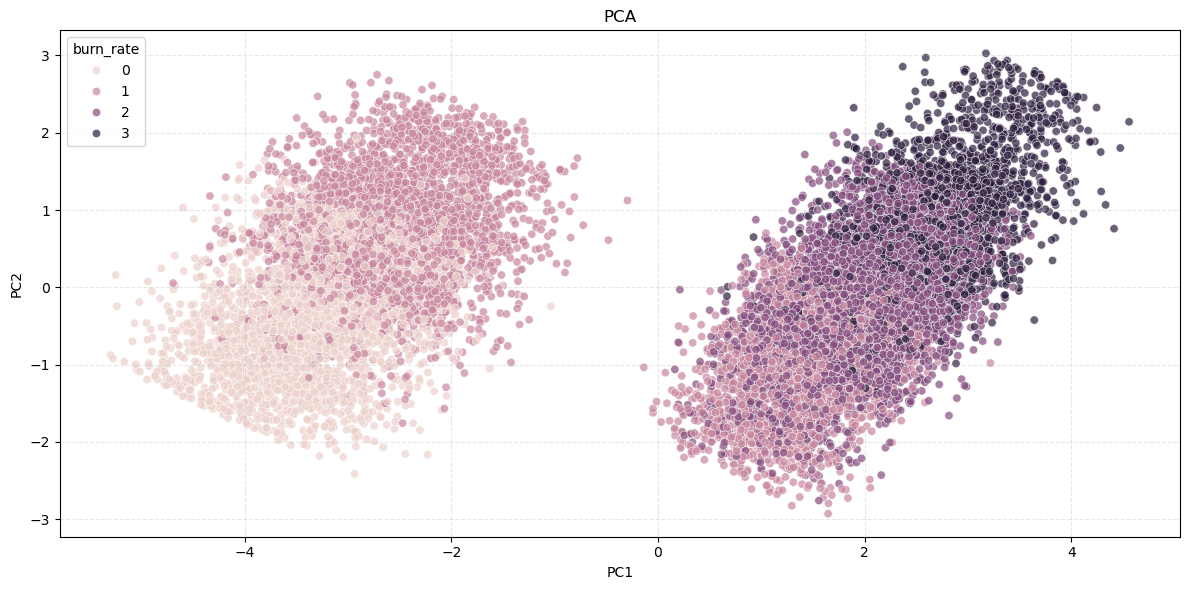

In [64]:
pca = PCA(n_components=5)
components = pca.fit_transform(X_train)
# Análisis de varianza 
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_.round(4))
print("Varianza acumulada:", np.cumsum(pca.explained_variance_ratio_).round(4))
df_components = pd.DataFrame(components, columns=['PC1', 'PC2','PC3', 'PC4', 'PC5'])
df_components['burn_rate'] = y_train
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='burn_rate', alpha=0.7)
plt.title('PCA')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 2) LDA (Linear Discriminant Analysis)

Es un método **supervisado** que proyecta los datos en ejes discriminantes que maximizan la separación entre clases del target mientras minimiza la varianza intraclase. Es útil para problemas de clasificación, ya que preserva - e incluso mejora - las diferencias entre grupos, manteniendo mayor interpretabilidad de qué variables contribuyen a la separación.

Varianza explicada por cada discriminante: [0.9692 0.0273 0.0036]
Varianza acumulada: [0.9692 0.9964 1.    ]


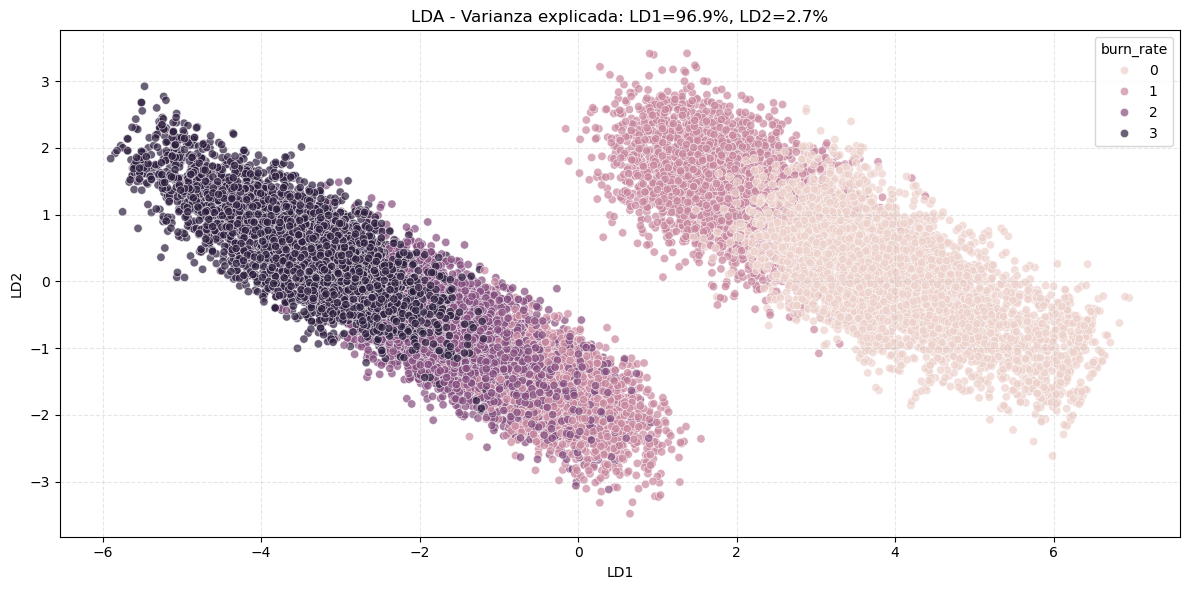

In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=3)  
components = lda.fit_transform(X_train, y_train) 
print("Varianza explicada por cada discriminante:", lda.explained_variance_ratio_.round(4))
print("Varianza acumulada:", np.cumsum(lda.explained_variance_ratio_).round(4))

df_components = pd.DataFrame(
    components, 
    columns=['LD1', 'LD2', 'LD3']  
)
df_components['burn_rate'] = y_train 
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_components, 
    x='LD1', 
    y='LD2', 
    hue='burn_rate', 
    alpha=0.7)
plt.title('LDA - Varianza explicada: LD1={:.1f}%, LD2={:.1f}%'.format(
    100 * lda.explained_variance_ratio_[0],
    100 * lda.explained_variance_ratio_[1]
))
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Los resultados muestran que el primer discriminante (LD1) explica ~96.92% de la varianza entre clases, mientras que LD2 y LD3 aportan muy poco (2.73% y 0.36%, respectivamente). Esto indica que LD1 domina completamente la separación de clases, casi el 97% de la distinción entre tus 4 categorías de burn_rate se captura en una sola dirección (LD1). Es probable que exista una variable latente que casi por sí sola explica las diferencias entre clases. LD2 y LD3 son marginales, su contribución es mínima (<3% combinada), lo que sugiere que las clases no se separan significativamente en estas direcciones. Reviso los pesos de LD1 para entender qué variabes impulsan la separación.


In [116]:
df_loadings = pd.DataFrame(
    lda.scalings_, 
    index=X_train.columns, 
    columns=['LD1', 'LD2', 'LD3']
)
print("Features más relevantes para LD1:")
print(df_loadings['LD1'].sort_values(ascending=False).head())

Features más relevantes para LD1:
designation                0.300528
work-life_balance_score    0.167170
recognition_frequency      0.130435
sleep_hours                0.111149
manager_support_score      0.040546
Name: LD1, dtype: float64


Evidentemente, *designation* es la variable que mas explica las diferencias entre las clases.

### Comparación PCA - LDA

LDA permite explicar mientras PCA (no supervisado) maximiza la varianza global de los datos, generando componentes que capturan la estructura subyacente sin considerar las clases (ej: PC1 explica 69.75% de la varianza, pero no garantiza separación entre categorías), LDA (supervisado) optimiza específicamente la separación entre clases, como se evidencia en su primer discriminante (LD1 explica 96.23% de la varianza entre grupos). PCA es ideal para reducir dimensionalidad preservando información general, pero LDA supera en problemas de clasificación al priorizar las features que mejor distinguen las categorías del target (ej: designation y work-life_balance_score en LD1). La elección depende del objetivo: exploración no supervisada (PCA) vs. clasificación interpretable (LDA).

### Comparación entre el dataset original y el reducido:

El dataset original conserva todas las variables, lo que permite una interpretación directa pero con riesgos de ruido, redundancia y sobreajuste en modelos complejos. Al aplicar reducción de dimensionalidad con PCA o LDA, se obtiene un dataset más compacto: PCA captura la estructura global mediante componentes que maximizan la varianza (útil para visualización y preprocesamiento), mientras que LDA genera discriminantes que optimizan la separación entre clases (ideal para clasificación). Esta reducción mejora la eficiencia computacional y reduce el overfitting, aunque puede sacrificar algo de interpretabilidad, especialmente con PCA.

### Impacto en modelos predictivos:

La reducción dimensional afecta directamente el rendimiento e interpretación de los modelos. PCA beneficia a algoritmos sensibles a dimensionalidad (como SVM) al eliminar ruido, pero podría perder información relevante para la clasificación. En cambio, LDA suele mejorar el accuracy en problemas supervisados al enfocarse en las variables que mejor distinguen las clases, ofreciendo además mayor claridad sobre qué features impulsan las predicciones.

## Balance de clases

Text(0.5, 1.0, 'train set')

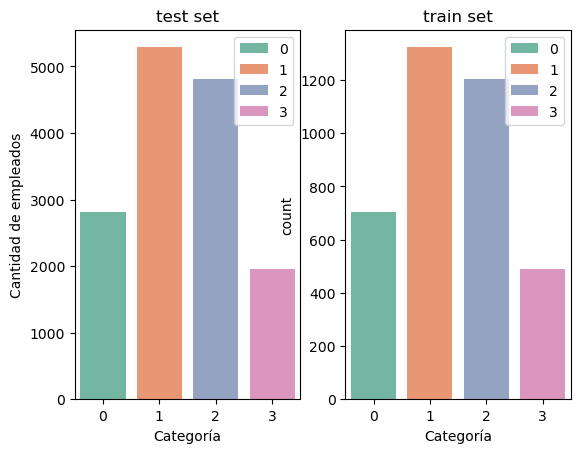

In [71]:
fig, axes = plt.subplots(1, 2)
sns.countplot(x=y_train, hue=y_train, palette="Set2", ax=axes[0])
axes[0].set_xlabel("Categoría")
axes[0].set_ylabel("Cantidad de empleados")
axes[0].set_title("test set")
sns.countplot(x=y_test, hue=y_test, palette="Set2", ax=axes[1])
axes[1].set_xlabel("Categoría")
axes[1].set_title("train set")

Para el set de entrenamiento, el dataset cuenta con menos de 2k muestras para
la clase minoritaria. Descartamos por lo tanto hacer under sampling a las otras
clases; ya que esto implicaría quedarse con cerca de 8k datos para entrenar
contra los casi 15 con los que cuenta actualmente. 

In [73]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

<Axes: ylabel='count'>

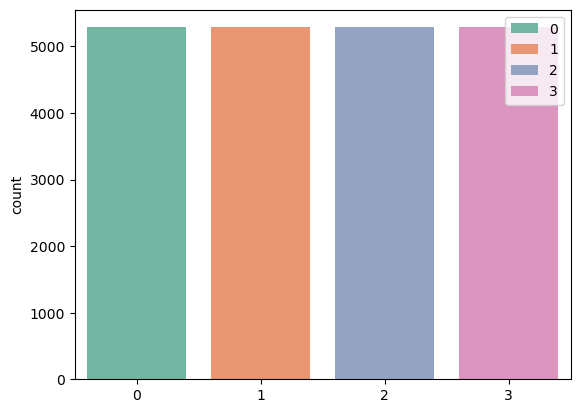

In [74]:
sns.countplot(x=y_train_sm, hue=y_train_sm, palette="Set2")

Por ahora podemos quedarnos con este set de entrenamiento. Hay que tener en cuenta
sin embargo que este over sampling de las clases minoritarias podria provocar
cierto overfitting al momento de entrenar el modelo. <br>
En este trabajo no llegamos a eso pero, si esto resulta en un problema
se podria buscar otra estrategia de balance, en primera instancia una
estrategia mixta *downsampleando* un poco la clase mayoritaria, para que
la síntesis de los datos minoritarios no sea tan grande.

In [76]:
X_train = X_train_sm
y_train = y_train_sm